**DSCI 100 Project**

**Introduction**

Heart disease is a prevalent disease throughout our world today due to the lifestyles and environmental factors that have been on the rise. In the United States, 48% of the population lives with heart disease. Notably, the vast majority of individuals live with a significant risk factor for heart disease. Risk factors include unhealthy BMI, abnormally high/low resting blood pressure, high resting heart rate, and old age. It is also important to consider that heart disease describes a range of conditions that affect the heart (congenital heart defects, arrhythmia, etc.).

This project will answer the question:   

“How accurately could the age, resting blood pressure, serum cholesterol, maximum heart rate, and ST depression* induced by exercise predictors in the Cleveland Heart Disease Data Set predict the presence of heart disease in an individual?”   

Our dataset originates from the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. The dataset includes attributes and variables measuring age, sex, cholesterol levels, resting blood pressure, etc.   

*An ST depression is a specific outcome that may appear in a person’s ECG results. It occurs when the ST segment appears abnormally low and sits below the baseline in a person’s results (Medical News Today). 


**Loading Data**

In [1]:
# First we load in the packages that will need to later use.
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)
library(themis)
library(kknn)
options(repr.matrix.max.rows = 6, repr.plot.width = 12, repr.plot.height = 10)

── Attaching packages ──────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
"package 'tidymodels' was built under R version 4.2.3"
── Attaching packages ─────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scal

In [2]:
set.seed(2000)

We read the raw heart disease data from the web.

In [3]:
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), 
                       col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                     "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


*Figure 1: title of this table*

**Each column represents the following:**

age - age of person in years  

sex - the person's sex  

cp - chest pain type 
- Value 1: typical angina
- Value 2: atypical angina
- Value 3: non-anginal pain, 
- Value 4: asymptomatic

trestbps - the resting blood pressure in mm Hg (unit of pressure)  

chol - serum cholesterol (mg/dl)  

fbs - fasting blood sugar > 120 mg/dl
- 1 = true
- 0 = false  

restecg - resting electrocardiographic results
- Value 0: normal  
- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)  
- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
                    
thalach - maximum heart rate achieved  

exercise induced angina
- 1 = true
- 0 = false

oldpeak - ST depression induced by exercise relative to rest  

slope - the slope of the peak exercise ST segment
- Value 1: upsloping
- Value 2: flat
- Value 3: downsloping

ca - number of major vessels (0-3) colored by flourosopy  

thal - thalassemia (a blood disorder that causes the body to have less hemoglobin than normal)
- Value 3: normal
- Value 6: fixed defect
- Value 7: reversable defect  

num - presence of heart disease    

**Choosing Predictors**

Now we select the columns that we may potentially use as predictors for our classification model. Categorical variables often do not make good predictors due to their rough distributions, so we will only consider numerical variables as candidates for potential predictors. We also mutate all cases where num > 0 to 1 as we simply want to determine if the patient has heart disease and not what stage of heart disease it is.

In [4]:
heart_selected <- select(heart_data, age, trestbps, chol, thalach, oldpeak, num) |>
    mutate(num = as_factor(case_when(num > 0 ~ 1, num == 0 ~ 0)))
heart_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
67,160,286,108,1.5,1
67,120,229,129,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,1
57,130,236,174,0.0,1
38,138,175,173,0.0,0


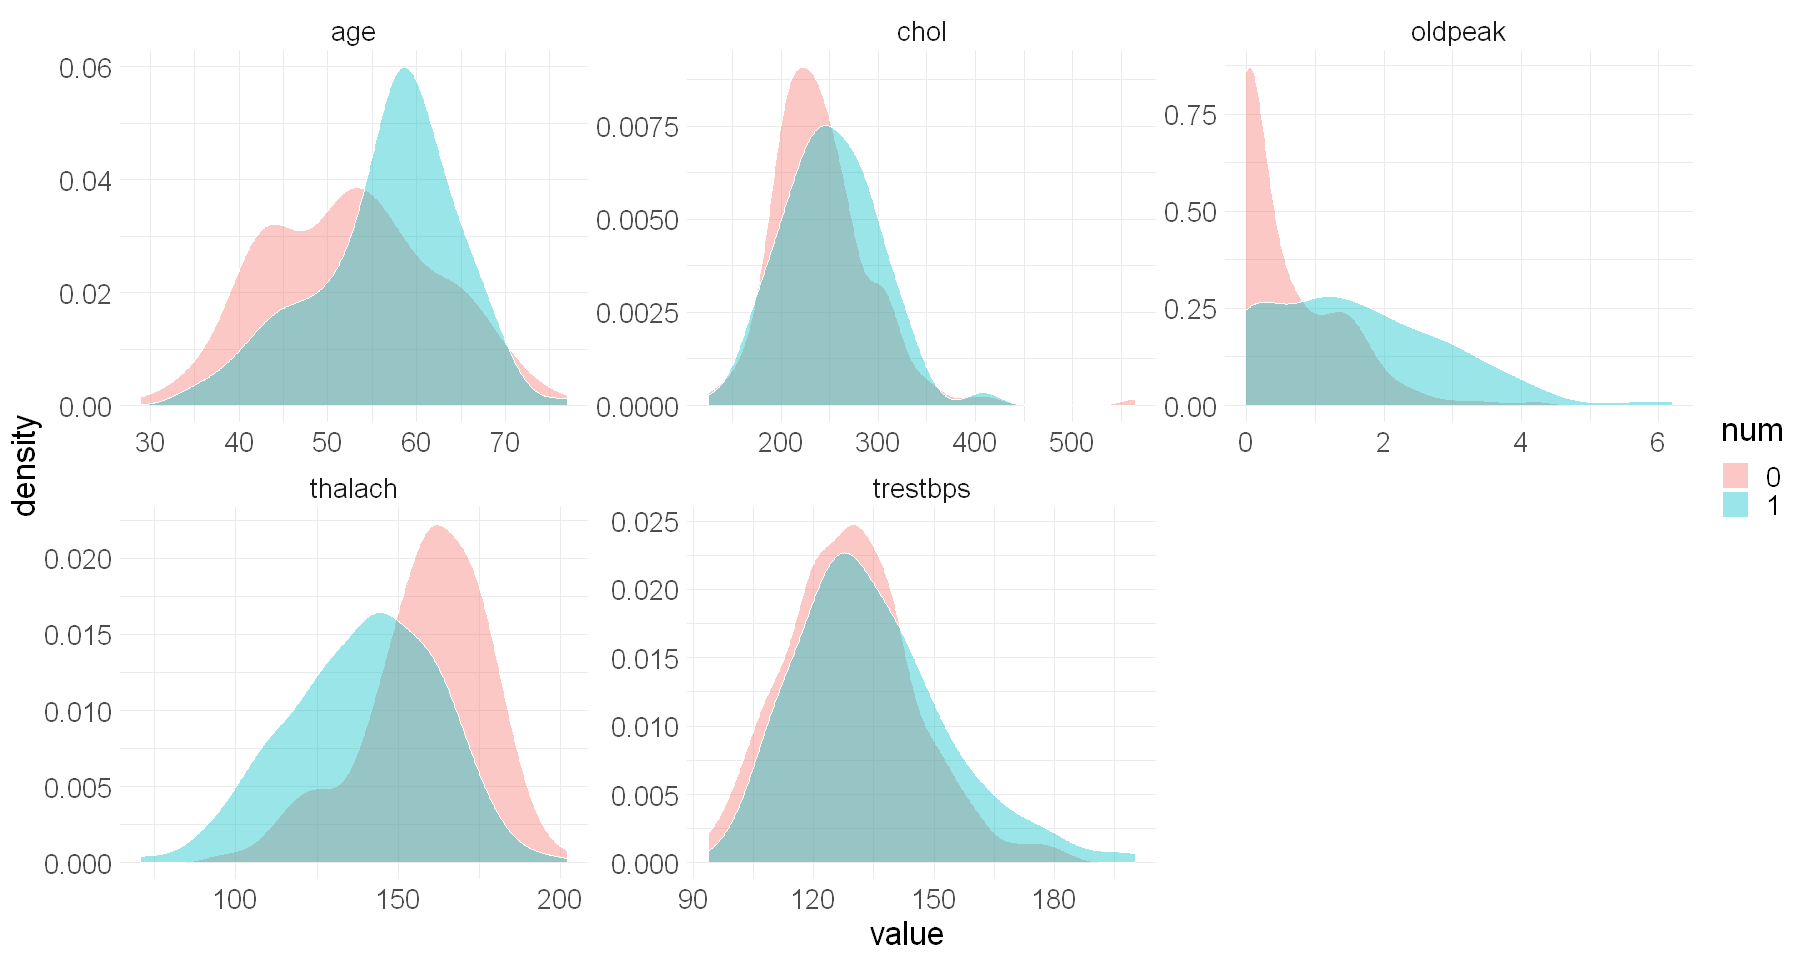

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 15)
heart_selected |>
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

*Figure 2: name this plot*

**Splitting training and testing data**

In [5]:
heart_split <- initial_split(heart_selected, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Table showing the number of observations and mean values of each class.

In [30]:
heart_sum <- heart_train |> 
    group_by(num) |> 
    summarize(count = n(), mean_age = mean(age), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
heart_sum

num,count,mean_age,mean_thalach,mean_oldpeak
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,123,52.75610,158.8293,0.5926829
1,104,56.52885,139.8942,1.5471154


*Figure 3: name this table*

**Determining the best "k" value for classification**

We use ggplot to make histograms in order to visualize the distribution of each potential predictor. This may be useful for when we decide which predictors to use. 

In [8]:
set.seed(2000)
heart_recipe <- recipe(num ~., data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>  
  set_engine("kknn") |>  
  set_mode("classification")  
  
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 5))

knn_results <- workflow() |>  
    add_recipe(heart_recipe) |>  
    add_model(knn_tune) |>  
    tune_grid(resamples = heart_vfold, grid = k_vals) |> 
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6218621,5,0.04193547,Preprocessor1_Model01
6,accuracy,binary,0.6792666,5,0.04434597,Preprocessor1_Model02
11,accuracy,binary,0.7056566,5,0.03406335,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
136,accuracy,binary,0.6748265,5,0.03301206,Preprocessor1_Model28
141,accuracy,binary,0.6657356,5,0.02729492,Preprocessor1_Model29
146,accuracy,binary,0.6438032,5,0.02853890,Preprocessor1_Model30


*Figure 4: name this table*

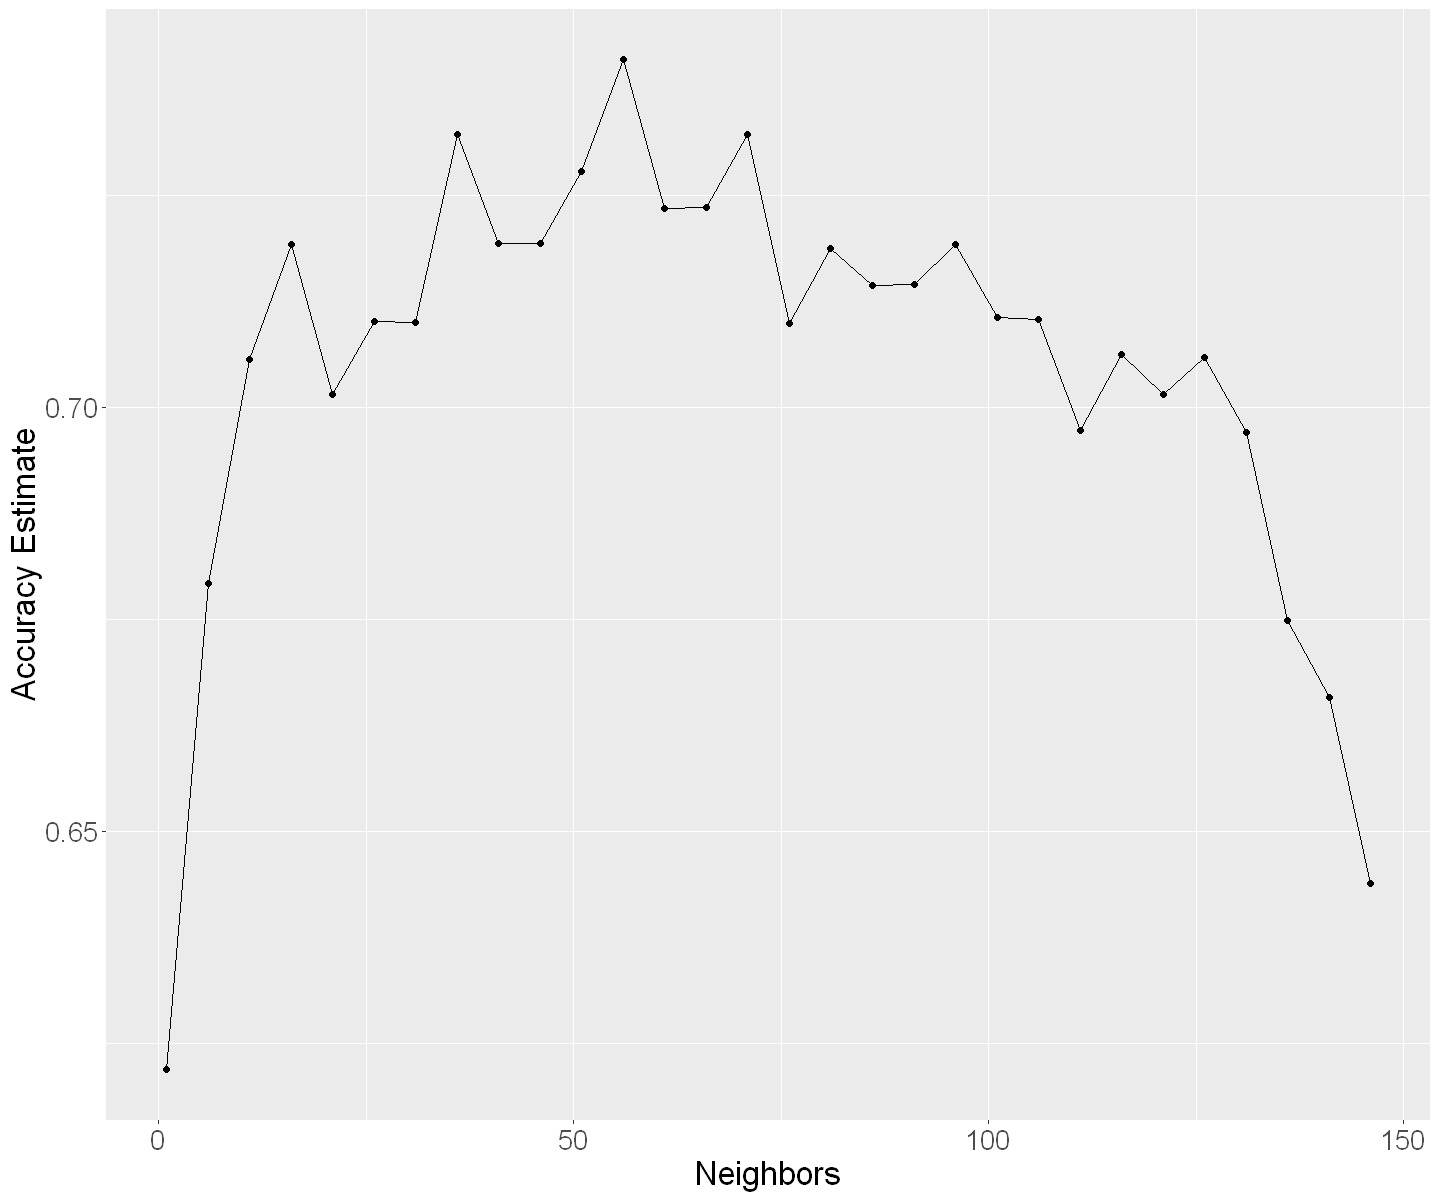

In [9]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))

accuracy_vs_k

*Figure 5: name this plot*

In [10]:
k_best <- accuracies |> 
    arrange(desc(mean)) |> 
    select(neighbors) |>
    head(1) |>
    pull()
k_best

[1] 56

**Training the classification model**

Now that we have determined our k value and predictors, the next step is to set up a workflow with a recipe and classifier and train the classifier using our training data. Now that the classification model has been created, we will test the accuracy of the model by passing the test data into the model. Our results will be visualized with a confusion matrix alongside scatterplots of the predictor variables. Each observation will include a fill color to illustrate its class. 

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 56) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_train)

knn_fit

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(56,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.277533
Best kernel: rectangular
Best k: 56

**Predicting the class of the test data**

In [12]:
heart_test_predictions <- predict(knn_fit, heart_test) |>
bind_cols(heart_test)

heart_test_predictions |>
metrics(truth = num, estimate = .pred_class) |>
filter(.metric == "accuracy") |> select(.estimate) |>
pull()

[1] 0.6973684

**Making a confusion matrix**

In [13]:
confusion <- heart_test_predictions |>
conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 32 14
         1  9 21

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


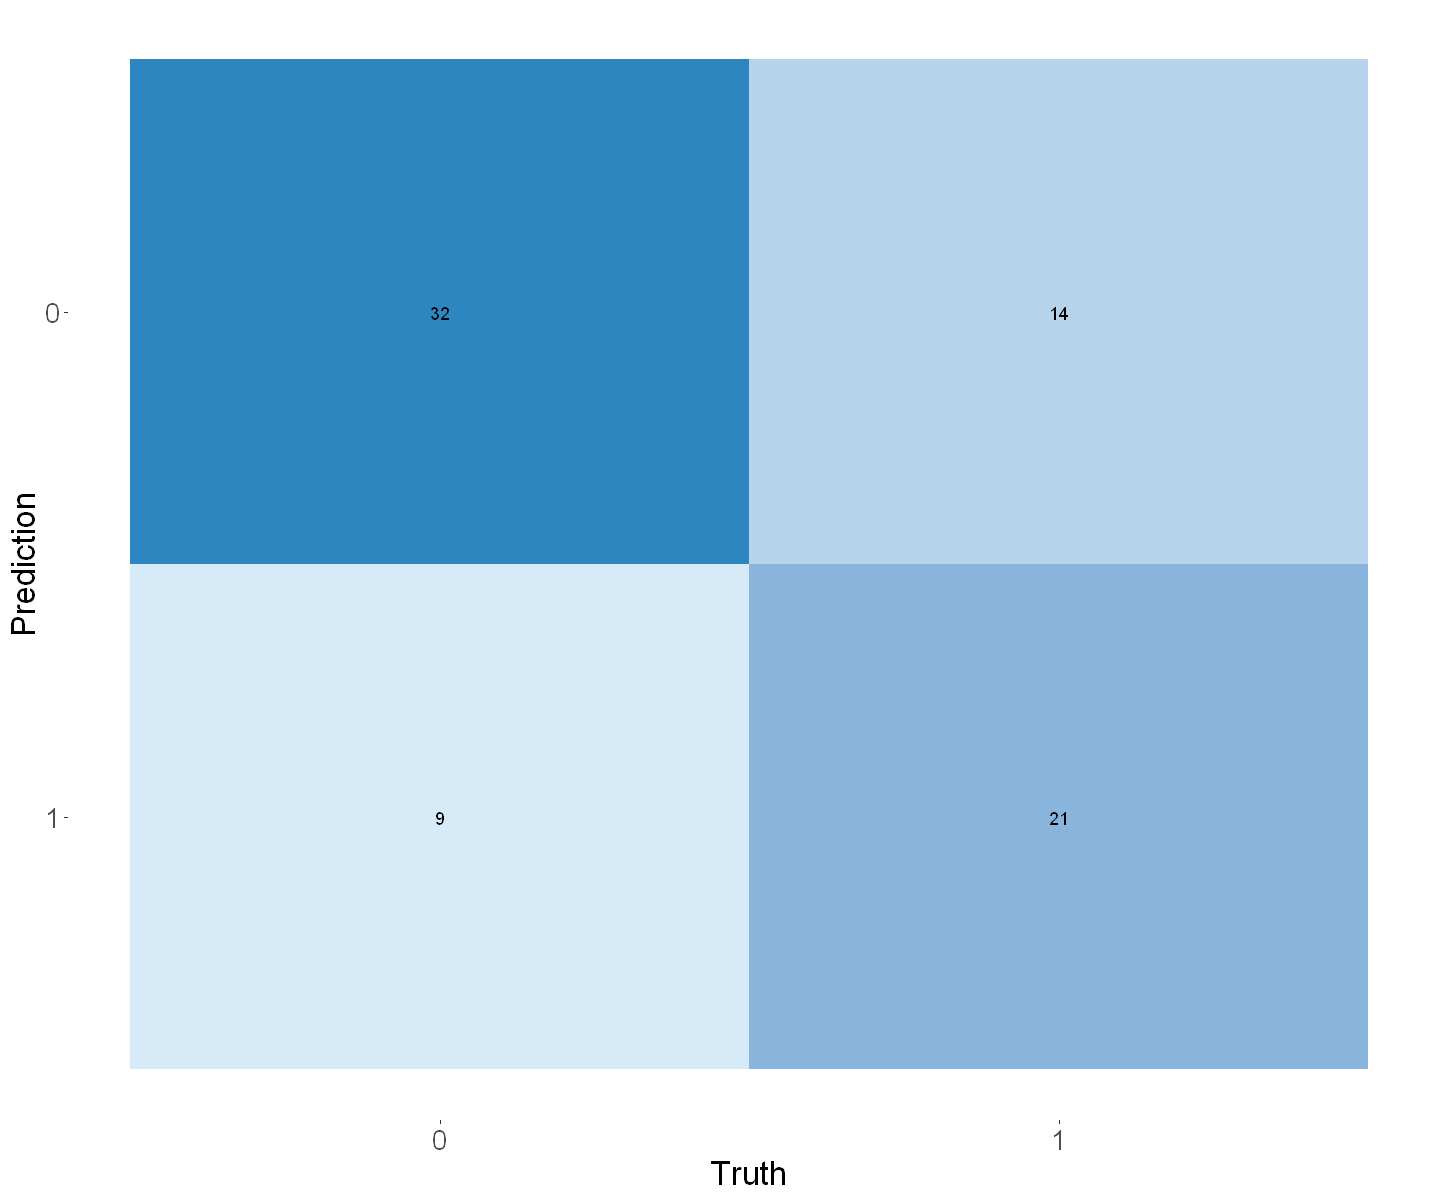

In [14]:
autoplot(confusion, type = "heatmap") +
    scale_fill_gradient(low="#D6EAF8",high = "#2E86C1") +
    theme(text = element_text(size = 20))

In [ ]:
#age_plot <- heart_test_predictions |> 
#    ggplot(aes(x = trestbps, y = thalach, color = num)) +
#    geom_point() +
#    labs(x = "Age", y = "Resting beats per minute", title = "Presence of Heart Disease with Respect to Age and Resting Heartbeat", color = "Presence of heart disease") +
#    theme(text = element_text(size = 20))
#age_plot

**Expected outcomes and significance:**

We expect to establish which variables in the heart disease data set are best suited to be used as predictors for determining the presence of heart disease and the accuracy it can be done with.  

The early prediction of heart disease may help prevent it in many individuals as well as allow for more effective treatment. This would not only save many lives but also serve to ease the financial burden on the healthcare system.  

This analysis could lead to questions of how heart disease can be prevented, including those around identifying additional risk factors. Further extensions could include analysis into how predictors could be identified prior to symptoms arising to prevent impacts of the disease. Additionally, similar frameworks can be applied to other chronic conditions with major burdens on individuals and healthcare systems. 


**Bibliography:**  

Cardiovascular diseases affect nearly half of American adults, statistics show. www.heart.org. (2021, November 23). Retrieved March 9, 2023, from https://www.heart.org/en/news/2019/01/31/cardiovascular-diseases-affect-nearly-half-of-american-adults-statistics-show  

Centers for Disease Control and Prevention. (2022, October 14). Heart disease facts. Centers for Disease Control and Prevention. Retrieved March 9, 2023, from https://www.cdc.gov/heartdisease/facts.htm  
    
 Hungarian Institute of Cardiology. (1988, July 1). Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. Retrieved March 9, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease